# 概要

### 背景
- ECサイトを初めて利用するとき、サイトに対する不安から低価格商品を購入する傾向がある
- 購入回数が増えるにつれて中価格・高価格商品の閲覧・購入傾向も高まると考えられる
- よって、購入回数がないまたは少ないユーザには低価格を、購入回数が複数回あるユーザには中価格・高価格商品をレコメンドすると良いと考える
- しかし、中価格・高価格な商品をレコメンドする最適なタイミングは不明である
- もし、中価格・高価格なものを購入するために必要な購入回数がわかれば、その回数から、中価格・高価格の商品をレコメンドすることで購入頻度・1回あたりの購入金額が増大する可能性があると考える

### 目的
- そこで今回は、購入回数ごとに購入者はどのページにアクセスしたかを明らかにする

### 分析方法
- 購入の有無を目的変数・閲覧ページの有無を説明変数として決定木を用いて分析をする
- 上記の分析を下記の対象のとおり購入回数ごとに分けて4回行う

|分析対象|目的変数|説明変数|
|---|---|---|
|全ユーザ     |1回目の購入有無|1回目購入ありユーザは初めてのサービス利用から1回目購入までの閲覧ページで、1回目購入無しユーザは初めてのサービス利用から最新までの閲覧ページ|
|1回以上購入者|2回目の購入有無|2回目購入ありユーザは1回目から2回目購入までの閲覧ページで、2回目購入無しユーザは1回目購入から最新までの閲覧ページ|
|2回以上購入者|3回目の購入有無|3回目購入ありユーザは2回目から3回目購入までの閲覧ページで、3回目購入無しユーザは2回目購入から最新までの閲覧ページ|
|3回以上購入者|4回目の購入有無|4回目購入ありユーザは3回目から4回目購入までの閲覧ページで、4回目購入無しユーザは3回目購入から最新までの閲覧ページ|

### 期待される成果
- この分析により、購入回数と閲覧したページカテゴリの関係性を明らかにすることで、中価格・高価格な商品をレコメンドする最適なタイミングを特定することができる
  - レコメンドから低価格を減らすことでより、中価格・高価格な商品を購入してもらえるようになると考える
- その結果、購入頻度と1回あたりの購入金額の増加に繋げることが期待できる

### 補足
- ECサイトのページは下記のとおり
  - 低価格_1：例) 文房具
  - 低価格_2：例) 日用品
  - 中価格_1：例) 洋服
  - 中価格_2：例) スポーツ・アウトドア
  - 高価格_1：例) 家電
  - 高価格_2：例) 家具


In [1]:
import numpy as np
import pandas as pd
import uuid

from numpy.random import *

In [2]:
def get_sumple_first(target_class_main, target_class_sub, p, ):
    SAMPLE_SIZE=10000
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']

    # 平均5, 標準偏差2の正規分布から値を一つ取り出してint型に変換（少数点以下切り捨て）
    visit_num = np.random.normal(5, 2, 1).astype(int)[0]

    lst_df=[]
    for i in range(0,SAMPLE_SIZE):
        # 1ユーザの行動を作成
        ## 閲覧ページ数が平均3、標準偏差1の分布から1の値を取得
        _visit_num = np.random.normal(3, 1, 1)[0]
        ## 閲覧ページ数を最大6に設定
        visit_num = np.clip(_visit_num, 1, 6).astype("int")
        # 閲覧ページ名を取得
        result_lst=np.random.choice(PRICE_CLASS, visit_num ,p=p)
        result=pd.Series(result_lst, name='閲覧ページ')
        ## 1ユーザあたりの行動をデータフレームに入れる
        df_result=result.to_frame()
        ## user_idを付与
        df_result['user_id']=str(uuid.uuid4())
        lst_df.append(df_result)

    df_base=pd.concat(lst_df, axis='index')
    df_drop_dupli=df_base.drop_duplicates()

    df_result=pd.concat([df_drop_dupli[['user_id']]
                        , pd.get_dummies(df_drop_dupli['閲覧ページ'])
                        ],
                        axis='columns').groupby('user_id').sum()

    e_z=randn(SAMPLE_SIZE)
    z_mean=(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}'] ).mean()

    # シグモイド関数を使ってtarget_class閲覧ユーザがより購入しやすいようにする
    z_base=np.array(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}']  -z_mean + 5*e_z)
    # シグモイド関数
    from scipy.special import expit
    # シグモイド関数を計算
    z_prob=expit(0.1*z_base)

    # 未購入 or 購入の変数(0は未購入、1は購入)
    Z=np.array([])

    for i in range(SAMPLE_SIZE):
        Z_i=np.random.choice(2 # 0 or 1のどちらかを取得するという意味
                            , size=1 # 1つの値だけ取得する
                            , p=[1-z_prob[i], z_prob[i]] # 購入する確率(1が入る確率)がz_prob[i]
                            )[0]
        Z=np.append(Z, Z_i).astype(int)


    df_result['result']=Z

    return df_result

In [3]:
def get_sumple_second_onwards(_df, target_class_main, target_class_sub, p):
    
    lst_id_first_buyer=_df[_df['result']==1].index
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']

    # 平均5, 標準偏差2の正規分布から値を一つ取り出してint型に変換（少数点以下切り捨て）
    visit_num = np.random.normal(5, 2, 1).astype(int)[0]

    lst_df=[]
    for id_first_buyer in lst_id_first_buyer:
        # 1ユーザの行動を作成
        ## 閲覧ページ数が平均3、標準偏差1の分布から1の値を取得
        _visit_num = np.random.normal(3, 1, 1)[0]
        ## 閲覧ページ数を最大6に設定
        visit_num = np.clip(_visit_num, 1, 6).astype("int")
        # 閲覧ページ名を取得
        result_lst=np.random.choice(PRICE_CLASS, visit_num ,p=p)
        result=pd.Series(result_lst, name='閲覧ページ')
        ## 1ユーザあたりの行動をデータフレームに入れる
        df_result=result.to_frame()
        ## user_idを付与
        df_result['user_id']=id_first_buyer
        lst_df.append(df_result)
    pd.concat(lst_df, axis='index')



    df_base=pd.concat(lst_df, axis='index')
    df_drop_dupli=df_base.drop_duplicates()

    df_result=pd.concat([df_drop_dupli[['user_id']]
                        , pd.get_dummies(df_drop_dupli['閲覧ページ'])
                        ],
                        axis='columns').groupby('user_id').sum()

    e_z=randn(len(lst_id_first_buyer))
    z_mean=(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}'] ).mean()

    # シグモイド関数を使ってtarget_class閲覧ユーザがより購入しやすいようにする
    z_base=np.array(30*df_result[f'{target_class_main}'] + 20*df_result[f'{target_class_sub}']  -z_mean + 5*e_z)
    # シグモイド関数
    from scipy.special import expit
    # シグモイド関数を計算
    z_prob=expit(0.1*z_base)

    # 未購入 or 購入の変数(0は未購入、1は購入)
    Z=np.array([])

    for i in range(len(lst_id_first_buyer)):
        Z_i=np.random.choice(2 # 0 or 1のどちらかを取得するという意味
                            , size=1 # 1つの値だけ取得する
                            , p=[1-z_prob[i], z_prob[i]] # 購入する確率(1が入る確率)がz_prob[i]
                            )[0]
        Z=np.append(Z, Z_i).astype(int)


    df_result['result']=Z

    return df_result

In [4]:
target_class_main='低価格_1'
target_class_sub='低価格_2'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]

df_first=get_sumple_first(target_class_main, target_class_sub, p)
df_first.head()

,中価格_1,中価格_2,低価格_1,低価格_2,高価格_1,高価格_2,result
user_id,,,,,,,
00016e95-1cf9-451c-8e79-3610e76df02e,0,0,1,0,0,0,1
00023d81-69ca-4532-b75e-7c1ee5a2b973,0,0,0,1,0,0,0
0008ac29-3933-4a7a-99d6-04988f4e0967,0,0,1,0,1,0,0
000a0146-fb42-4d7c-bf1e-d02292909304,1,0,1,0,0,0,0
000f2a11-561e-4a14-960b-b1212e6d42ea,0,0,0,0,0,1,0


In [5]:
target_class_main='低価格_1'
target_class_sub='低価格_2'
p=[0.4, 0.4, 0.05, 0.05, 0.05, 0.05]

df_second=get_sumple_second_onwards(df_first, target_class_main, target_class_sub, p)

In [6]:
target_class_main='低価格_2'
target_class_sub='中価格_1'
p=[0.1, 0.2, 0.4, 0.1, 0.1, 0.1]

df_third=get_sumple_second_onwards(df_second, target_class_main, target_class_sub, p)

In [7]:
target_class_main='中価格_1'
target_class_sub='高価格_2'
p=[0.1, 0.15, 0.25, 0.1, 0.1, 0.3]

df_4th=get_sumple_second_onwards(df_third, target_class_main, target_class_sub, p)

In [8]:
import matplotlib.pyplot as plt # グラフ等の描画用モジュール
from sklearn.model_selection import train_test_split # データを学習用とテスト用に分割する関数
from sklearn.tree import DecisionTreeClassifier # 決定木（分類）

from sklearn.metrics import confusion_matrix, accuracy_score

import sklearn.tree
import japanize_matplotlib

In [9]:
def make_cm(matrix, columns):
    # columns 項目名リスト
    n = len(columns)

    # '正解データ'をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    #データフレーム生成
    cm = pd.DataFrame(matrix, 
        columns=[pred, columns], index=[act, columns])
    
    return cm

In [10]:
def get_DT_result(df):
    PRICE_CLASS=['低価格_1', '低価格_2', '中価格_1', '中価格_2', '高価格_1', '高価格_2']
    x=df[PRICE_CLASS]
    t=df['result']
    x_train, x_test, t_train, t_test = train_test_split(x, t, 
                                                        stratify=t, 
                                                        random_state=0)

    tree_2 = DecisionTreeClassifier(max_depth=2, random_state=0)
    tree_2.fit(x_train, t_train)

    # 予測
    predicted = tree_2.predict(x_test)
    print('accuracy', accuracy_score(t_test, predicted))

    _cm = confusion_matrix(t_test, predicted)
    cm = make_cm(_cm, ['未購入', '購入'])

    
    # 結果の表示
    display(cm)

    # 決定木を可視化
    plt.figure(figsize=(20, 8))
    sklearn.tree.plot_tree(tree_2, # モデルの名前 
                        class_names=['未購入', '購入'], # クラス名
                        feature_names=PRICE_CLASS, # ラベル名
                        filled=True # 色付きで表示
                        )
    plt.show()

accuracy 0.758


予測結果     
            未購入   購入
正解データ 未購入  1048  183
      購入    422  847

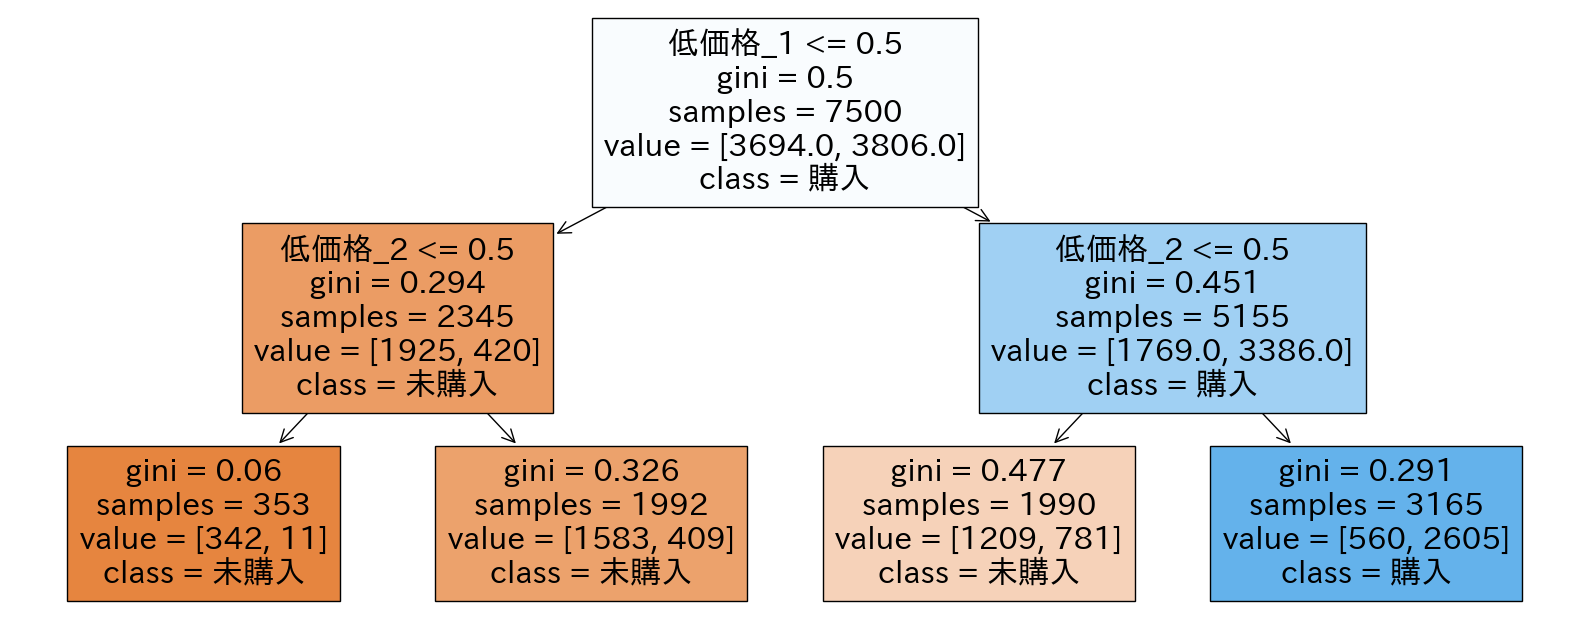

In [11]:
get_DT_result(df_first)

accuracy 0.7620173364854216


予測結果     
           未購入   購入
正解データ 未購入  530   98
      購入   204  437

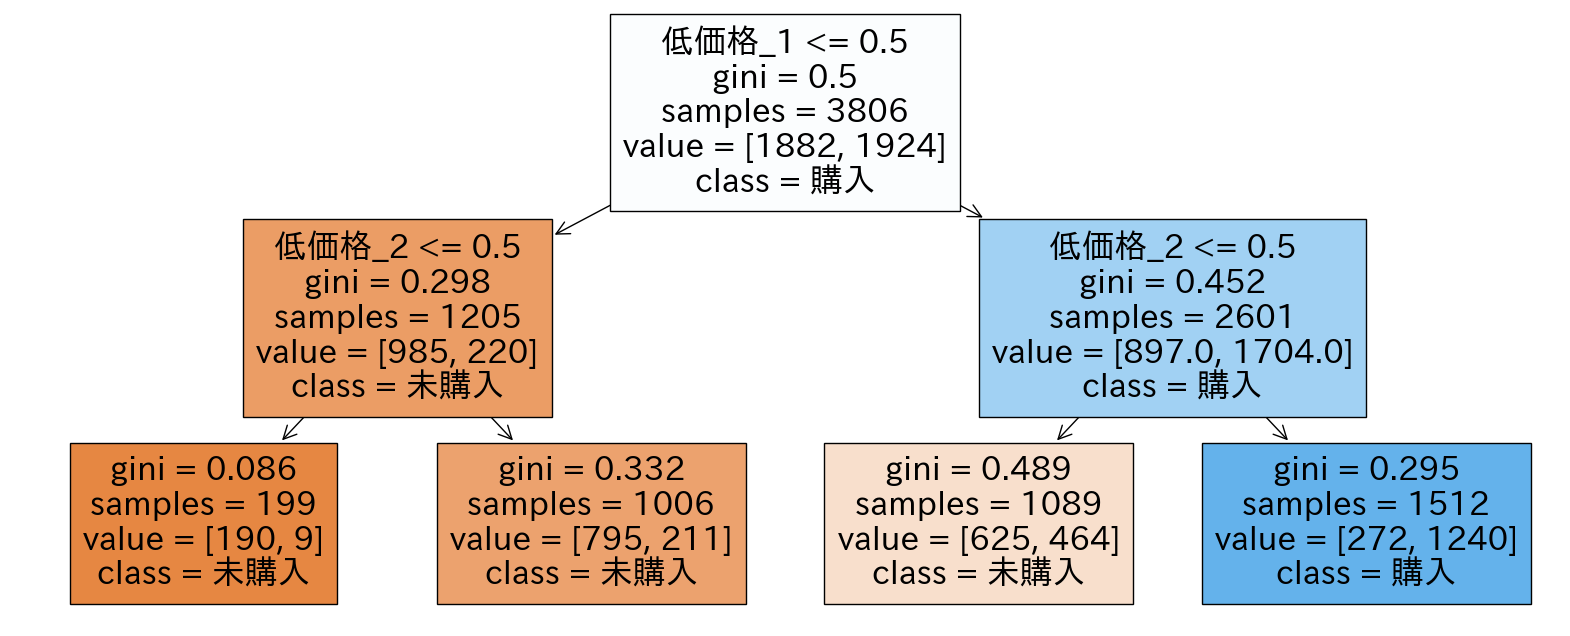

In [12]:
get_DT_result(df_second)


accuracy 0.7149532710280374


予測結果     
           未購入   購入
正解データ 未購入  313   21
      購入   162  146

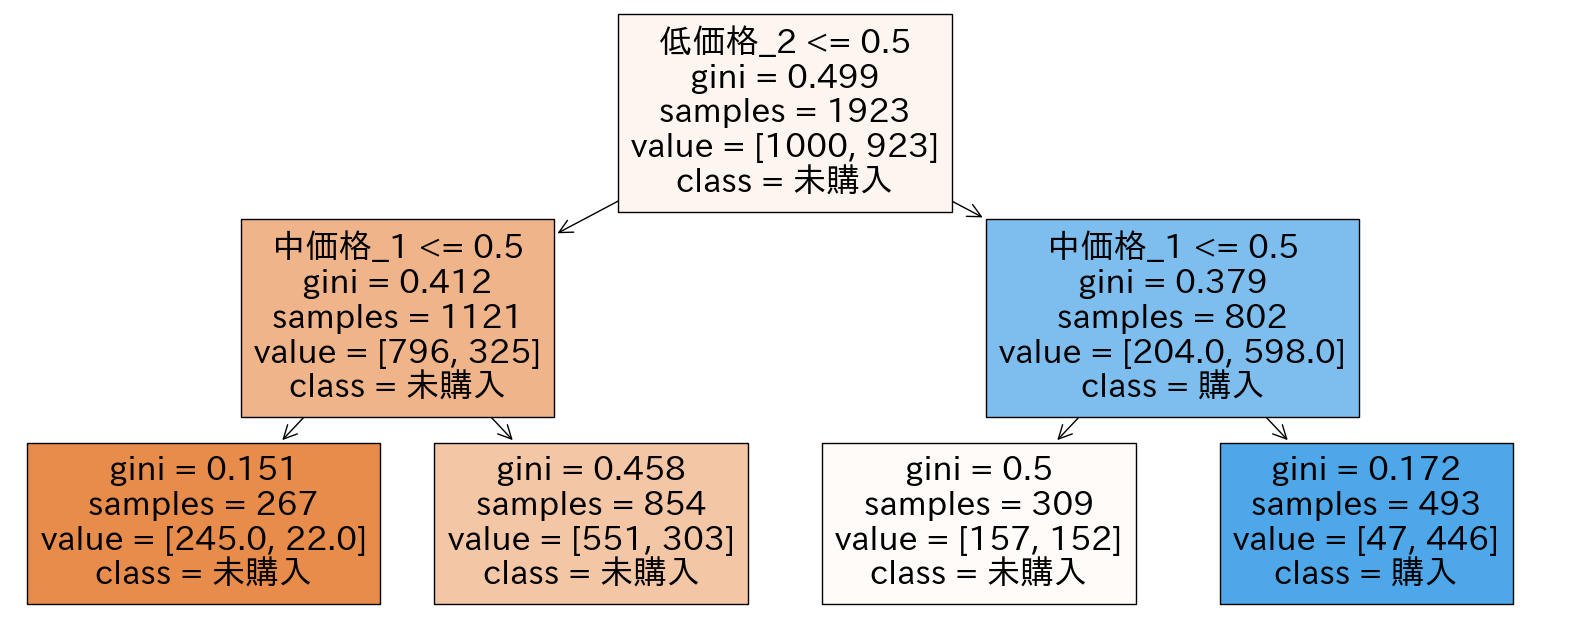

In [13]:
get_DT_result(df_third)

accuracy 0.762987012987013


予測結果     
           未購入   購入
正解データ 未購入  119   39
      購入    34  116

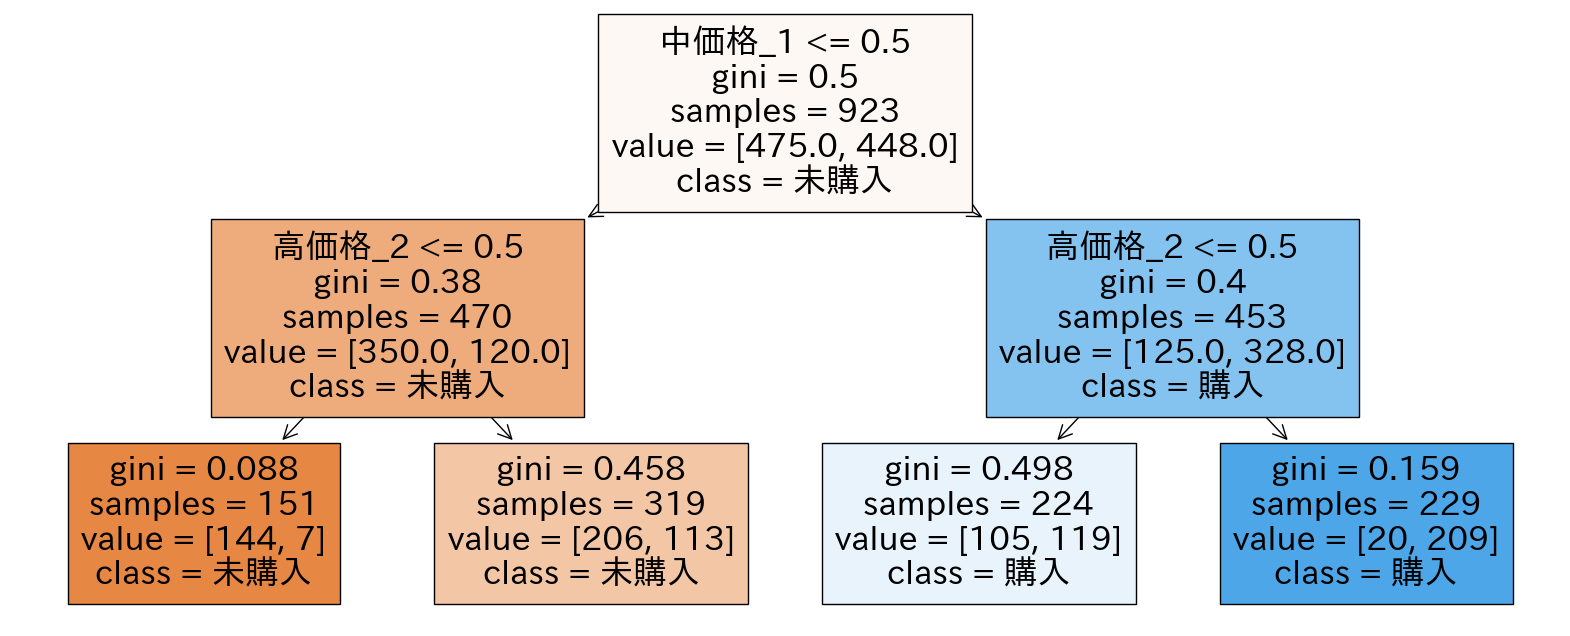

In [14]:
get_DT_result(df_4th)

# 結果
- 購入者は購入回数が
  - 1回目と2回目では、低価格を閲覧している
  - 3回目では低価格に加えて中価格も閲覧している
  - 4回目では中価格に加えて高価格も閲覧している

よって、2回購入したユーザには中価格をレコメンドし、3回購入したユーザには中価格に加えて高価格もレコメンドすることが最適なタイミングであると考える